[INFO] Loading model: /Users/imalsky/Desktop/Gos_New/models/trained_model_optimized_v1/export_eager.pt
[INFO] Successfully loaded model (globals=['P', 'T'])
g shape before norm: (1, 2)
gn shape after norm: torch.Size([1, 2]), gn: tensor([[ 0.3000, -0.8367]])
predict_series_k1 - Initial gn shape: torch.Size([1, 2]), type: <class 'torch.Tensor'>
predict_series_k1 - After reshape gn shape: torch.Size([1, 2])
  Iteration 0: gn shape before fn call: torch.Size([1, 2])
  Iteration 0: y0n shape: torch.Size([1, 13]), t_hat[0] shape: torch.Size([1])
  Iteration 0: Calling fn with gn_input shape: torch.Size([1, 2])
  Iteration 1: gn shape before fn call: torch.Size([1, 2])
  Iteration 1: y0n shape: torch.Size([1, 13]), t_hat[1] shape: torch.Size([1])
  Iteration 1: Calling fn with gn_input shape: torch.Size([1, 2])
  Iteration 2: gn shape before fn call: torch.Size([1, 2])
  Iteration 2: y0n shape: torch.Size([1, 13]), t_hat[2] shape: torch.Size([1])
  Iteration 2: Calling fn with gn_input shape

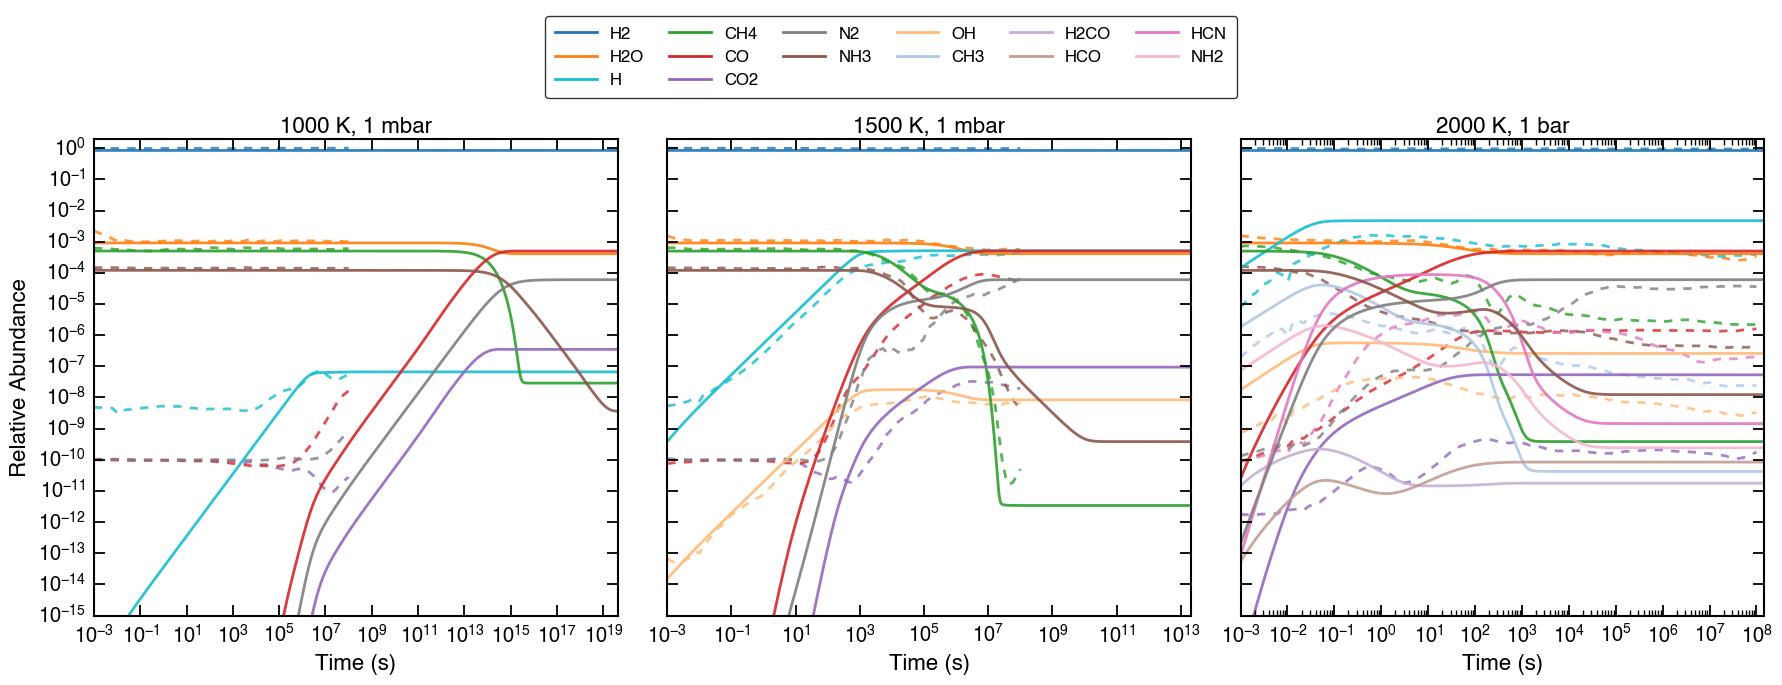

In [17]:
#!/usr/bin/env python3
"""
Simplified xi_tests for Jupyter - Fixed globals handling with debugging
"""

from __future__ import annotations
import os, sys, json
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.style.use('science.mplstyle')

# Setup paths
HERE = Path.cwd()
REPO_ROOT = HERE.parent
MODEL_DIR = REPO_ROOT / "models" / "trained_model_optimized_v1"
PROCESSED_DIR = REPO_ROOT / "data" / "processed"
SRC_DIR = REPO_ROOT / "src"

torch.set_num_threads(1)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

sys.path.append(str(SRC_DIR))
from normalizer import NormalizationHelper
from model import create_model

# Fixed targets
TARGET_SPECIES = [
    "C2H2_evolution","CH3_evolution","CH4_evolution","CO2_evolution","CO_evolution",
    "H2O_evolution","H2_evolution","HCN_evolution","H_evolution","N2_evolution",
    "NH3_evolution","OH_evolution","O_evolution",
]
BASE_NAMES = [s[:-10] for s in TARGET_SPECIES]

# Constants
T_MIN, T_MAX = 1e-3, 1e8
K = 99
FLOOR = 1e-10
PLOT_FLOOR = 1e-30

# Color map
color_map = {
    'H2': '#1f77b4', 'H2O': '#ff7f0e', 'CH4': '#2ca02c', 'CO': '#d62728',
    'CO2': '#9467bd', 'NH3': '#8c564b', 'HCN': '#e377c2', 'N2': '#7f7f7f',
    'C2H2': '#bcbd22', 'H': '#17becf', 'CH3': '#aec7e8', 'OH': '#ffbb78', 'O': '#98df8a',
    'H2CO': '#c5b0d5', 'HCO': '#c49c94', 'NH2': '#f7b6d2'
}

# Test cases
CASE_DEFS = [
    dict(
        label="1000 K, 1 mbar",
        T_K=1000.0,
        P_Pa=100.0,
        test_species=['H2', 'H2O', 'H', 'CH4', 'CO', 'CO2', 'N2', 'NH3', 'He'],
        values=[9.975331e-01, 1.074060e-03, 0.0, 5.902400e-04, 0.0, 0.0, 0.0, 1.415900e-04, 1.679000e-01],
        VULCAN_PATH=Path("/Users/imalsky/Desktop/Chemistry_Project/Vulcan/0D_full_NCHO/solar/vul-T1000KlogP3.0-NCHO-solar_hot_ini.vul"),
    ),
    dict(
        label="1500 K, 1 mbar",
        T_K=1500.0,
        P_Pa=100.0,
        test_species=['OH', 'H2', 'H2O', 'H', 'CH4', 'CO', 'CO2', 'N2', 'NH3', 'He'],
        values=[0.0, 9.975331e-01, 1.074060e-03, 0.0, 5.902400e-04, 0.0, 0.0, 0.0, 1.415900e-04, 1.679000e-01],
        VULCAN_PATH=Path("/Users/imalsky/Desktop/Chemistry_Project/Vulcan/0D_full_NCHO/solar/vul-T1500KlogP3.0-NCHO-solar_hot_ini.vul"),
    ),
    dict(
        label="2000 K, 1 bar",
        T_K=2000.0,
        P_Pa=1.0e5,
        test_species=['OH', 'H2', 'H2O', 'H', 'CH3', 'CH4', 'CO', 'CO2', 'H2CO', 'HCO', 'HCN', 'NH2', 'N2', 'NH3', 'He'],
        values=[0.0, 9.975331e-01, 1.074060e-03, 0.0, 0.0, 5.902400e-04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.415900e-04, 1.679000e-01],
        VULCAN_PATH=Path("/Users/imalsky/Desktop/Chemistry_Project/Vulcan/0D_full_NCHO/solar/vul-T2000KlogP5.0-NCHO-solar_hot_ini.vul"),
    ),
]

def load_norm_and_model():
    # Load normalization manifest
    with open(PROCESSED_DIR / "normalization.json", "r") as f:
        manifest = json.load(f)
    norm = NormalizationHelper(manifest)
    
    # Load checkpoint
    model_path = MODEL_DIR / "export_eager.pt"
    print(f"[INFO] Loading model: {model_path}")
    checkpoint = torch.load(str(model_path), map_location='cpu')
    
    # Use config from checkpoint
    config = checkpoint['config']
    state_dict = checkpoint['state_dict']
    
    # Fix paths to be absolute
    config['paths']['processed_data_dir'] = str(PROCESSED_DIR)
    
    # Get global variables from config
    globals_v = config['data'].get('global_variables', [])
    
    # Create model and load weights
    model = create_model(config)
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    
    print(f"[INFO] Successfully loaded model (globals={globals_v})")
    return norm, globals_v, model

def make_y0_noHe_from_withHe(species_with_he, values_with_he):
    base_to_val = {k: float(v) for k, v in zip(species_with_he, values_with_he)}
    raw = np.array([max(base_to_val.get(b, FLOOR), FLOOR) for b in BASE_NAMES], dtype=np.float64)
    return (raw / raw.sum()).astype(np.float32)

@torch.inference_mode()
def predict_series_k1(fn, y0n, gn, t_hat):
    # Debug: Check inputs
    print(f"predict_series_k1 - Initial gn shape: {gn.shape}, type: {type(gn)}")
    
    # Ensure inputs are tensors with correct shapes
    if not isinstance(y0n, torch.Tensor):
        y0n = torch.as_tensor(y0n)
    if not isinstance(gn, torch.Tensor):
        gn = torch.as_tensor(gn)
    if not isinstance(t_hat, torch.Tensor):
        t_hat = torch.as_tensor(t_hat)
    
    # Ensure 2D shapes
    if y0n.ndim == 1:
        y0n = y0n.reshape(1, -1)
    if gn.ndim == 1:
        gn = gn.reshape(1, -1)
    
    print(f"predict_series_k1 - After reshape gn shape: {gn.shape}")
    
    out = []
    for k in range(min(3, int(t_hat.numel()))):  # Only do first 3 iterations for debugging
        print(f"  Iteration {k}: gn shape before fn call: {gn.shape}")
        print(f"  Iteration {k}: y0n shape: {y0n.shape}, t_hat[{k}] shape: {t_hat[k:k+1].shape}")
        
        # Try with contiguous tensors
        y0n_input = y0n.contiguous()
        gn_input = gn.contiguous()
        t_input = t_hat[k:k+1].contiguous()
        
        print(f"  Iteration {k}: Calling fn with gn_input shape: {gn_input.shape}")
        
        yk = fn(y0n_input, t_input, gn_input)
        if not isinstance(yk, torch.Tensor):
            yk = torch.as_tensor(yk)
        out.append(yk.reshape(1, -1))
    
    # Complete the rest without debug
    for k in range(3, int(t_hat.numel())):
        yk = fn(y0n.contiguous(), t_hat[k:k+1].contiguous(), gn.contiguous())
        if not isinstance(yk, torch.Tensor):
            yk = torch.as_tensor(yk)
        out.append(yk.reshape(1, -1))
    
    return torch.cat(out, dim=0).cpu().numpy()

def load_vulcan(pickle_path):
    import pickle
    with open(pickle_path, "rb") as h:
        d = pickle.load(h)
    t = np.asarray(d["variable"]["t_time"], dtype=float)
    Y = np.asarray(d["variable"]["y_time"], dtype=float)
    den = np.maximum(Y[:,0,:].sum(axis=-1), 1e-30)
    MR = Y[:,0,:] / den[:,None]
    species_list = list(d["variable"]["species"])
    return d, t, MR, species_list

# Main execution
norm, globals_v, fn = load_norm_and_model()

eps = float(getattr(norm, "epsilon", 1e-30))
t_phys = np.logspace(np.log10(T_MIN), np.log10(T_MAX), K, dtype=np.float32)
t_hat = norm.normalize_dt_from_phys(torch.from_numpy(np.clip(t_phys, eps, None)))

fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)

# Build legend allowed list
legend_allowed_order = []
seen = set()
for case in CASE_DEFS:
    for sp in case["test_species"]:
        if sp != "He" and sp not in seen:
            seen.add(sp)
            legend_allowed_order.append(sp)

plotted_labels = set()

for ax, case in zip(axes, CASE_DEFS):
    test_set = [s for s in case["test_species"] if s != "He"]
    test_set_set = set(test_set)
    
    # Build y0 and globals
    y0_noHe = make_y0_noHe_from_withHe(case["test_species"], case["values"])
    
    # Build globals array with proper values
    P_barye = float(case["P_Pa"]) * 10.0
    g = np.zeros((1, len(globals_v)), dtype=np.float32)
    for i, name in enumerate(globals_v):
        n = name.strip().lower()
        if n.startswith("p"):
            g[0, i] = P_barye
        elif n.startswith("t"):
            g[0, i] = float(case["T_K"])
        else:
            g[0, i] = 0.0
    
    # Debug print to see what's happening
    print(f"g shape before norm: {g.shape}")
    
    # Normalize
    y0n = norm.normalize(torch.from_numpy(y0_noHe.reshape(1, -1)), TARGET_SPECIES)
    gn = norm.normalize(torch.from_numpy(g), globals_v)
    
    # Debug print after normalization
    print(f"gn shape after norm: {gn.shape}, gn: {gn}")
    
    # Ensure gn is 2D
    if gn.ndim == 1:
        gn = gn.reshape(1, -1)
        print(f"Reshaped gn to: {gn.shape}")
    
    ypred_n = predict_series_k1(fn, y0n, gn, t_hat)
    ypred = norm.denormalize(torch.from_numpy(ypred_n), TARGET_SPECIES).numpy()
    
    # Plot model curves (dashed)
    for i, base_name in enumerate(BASE_NAMES):
        if base_name in test_set_set:
            color = color_map.get(base_name, '#333333')
            ax.loglog(t_phys, np.maximum(ypred[:, i], PLOT_FLOOR),
                     '--', lw=2, color=color, alpha=0.8, label=base_name)
            plotted_labels.add(base_name)
    
    # VULCAN overlay (solid)
    if case["VULCAN_PATH"].exists():
        d, t_v, MR, file_species = load_vulcan(case["VULCAN_PATH"])
        present = [sp for sp in test_set if sp in file_species]
        for sp in present:
            idx = file_species.index(sp)
            color = color_map.get(sp, '#333333')
            ax.loglog(t_v, np.maximum(MR[:, idx], PLOT_FLOOR),
                     '-', lw=2, color=color, alpha=0.9, label=sp)
            plotted_labels.add(sp)
    
    # Axes configuration
    ax.set_xlabel("Time (s)", fontsize=16, fontweight='medium')
    if ax.get_lines():
        ax.set_xlim(left=1e-3, right=max(np.nanmax(l.get_xdata()) for l in ax.get_lines()))
    else:
        ax.set_xlim(1e-3, 1e8)
    ax.set_ylim(1e-15, 2)
    ax.set_title(case["label"], fontsize=16)
    if ax is axes[0]:
        ax.set_ylabel("Relative Abundance", fontsize=16, fontweight='medium')

# Global legend
legend_labels = [lbl for lbl in legend_allowed_order if lbl in plotted_labels]
handles = [Line2D([0], [0], color=color_map.get(lbl, '#333333'), lw=2, linestyle='-') 
          for lbl in legend_labels]

fig.subplots_adjust(top=0.83)
if handles:
    fig.legend(handles, legend_labels,
               loc='upper center',
               ncol=min(len(legend_labels), 6),
               frameon=True,
               borderpad=0.6,
               columnspacing=1.5,
               handlelength=2.5,
               fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.savefig("xi_tests.png", dpi=250)
plt.show()